In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.wcs import WCS
from astropy.io import fits


from scipy.stats import truncnorm, norm
from scipy.optimize import minimize

In [120]:
# filter_band_kwarg = 'f200w'
filter_band_kwarg = 'f277w'
list_of_relevant_files = glob.glob('/home/walml/repos/gz-jwst/data/dev_data/hlsp_ceers*{}*i2d.fits.gz'.format(filter_band_kwarg))
filename = list_of_relevant_files[0]
fits_ext = 2  # TODO

In [121]:
filename

'/home/walml/repos/gz-jwst/data/dev_data/hlsp_ceers_jwst_nircam_nircam6_f277w_v0.5_i2d.fits.gz'

In [122]:
image_data, image_header = fits.getdata(filename, memmap=True, ext=fits_ext, header=True)

In [123]:

image_wcs = WCS(image_header)

# https://archive.stsci.edu/hlsps/ceers/hlsp_ceers_jwst_nircam-miri_multi_multi_v0.6_readme.txt

"""The NIRCam images are multi-extension fits files with 13 extensions:
  0. PRIMARY header
  1. SCI_BKSUB  - 2D background-subtracted science image
  2. SCI  - 2D science image (not background subtracted)
  3. ERR  - 2D array of uncertainties, given as standard deviation and
            constructed as the sum in quadrature of the resampled variance maps
  4. CON  - 2D context image, encoding info about which input images
            contribution to each output pixel
  5. WHT  - 2D weight image giving the relative weight of the output pixels,
            constructed from the VAR_RNOISE map during resampling
  6. VAR_POISSON  - 2D variance array based on Poisson noise only
  7. VAR_RNOISE  - 2D variance array based on read noise only
  8. VAR_FLAT  - 2D variance array based on uncertainty in the flat-field
  9. BKGD  - 2D background model subtracted from the science image
 10. BKGMASK  - the tiered source mask used to create the background
 11. HDRTAB  - table containing metadata (FITS keyword values) for all the
               input images
 12. ASDF  - metadata for the JWST data model
"""

# note that science image is already background-subtracted, no need to do more background subtraction
# but we might use these to check the subtraction is reasonable
background_info = {
    'science_image': fits.getdata(filename, memmap=True, ext=2),
    'science_image_bkg_subtracted': fits.getdata(filename, memmap=True, ext=1),
    'background': fits.getdata(filename, memmap=True, ext=9),
    'background_source_mask': fits.getdata(filename, memmap=True, ext=10),
    'uncertainties': fits.getdata(filename, memmap=True, ext=3)
}


Set DATE-AVG to '2022-06-22T08:13:22.179' from MJD-AVG.
Set DATE-END to '2022-06-22T08:39:20.828' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.849188 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725785823.910 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [124]:
background_info['science_image_bkg_subtracted'].shape

(4800, 10500)

In [125]:
background_info['background_source_mask'].shape

(4800, 10500)

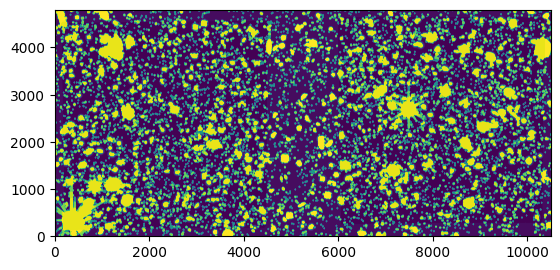

In [126]:
plt.imshow(background_info['background_source_mask'], origin='lower')

((7950889,), 0.00010000031015646805, 0.004999994311058861)

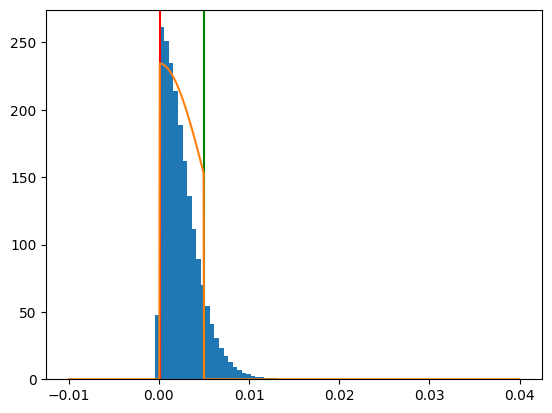

In [127]:
# handful of values set to crazy values
nominal_bkg = background_info['science_image_bkg_subtracted'][~background_info['background_source_mask'].astype(bool)]
nominal_bkg = nominal_bkg[nominal_bkg < 1e5]
nominal_bkg = nominal_bkg[nominal_bkg < 1]
nominal_bkg = nominal_bkg[nominal_bkg > 1e-5]

# nominal_bkg = nominal_bkg ** .99

bins = np.linspace(-0.01, .04, 100)
_ = plt.hist(
    nominal_bkg.flatten(),
    bins=bins,
    density=True
)

low_mode = 1e-4
plt.axvline(low_mode, color='red')

high_mode = 0.005
# high_mode = np.inf
plt.axvline(high_mode, color='green')

x = np.linspace(-0.01, .04, 1000)
# scale = 0.00565
scale = 5.376e-3
y = truncnorm.pdf(x, scale=scale, a=low_mode/scale, b=high_mode/scale)
plt.plot(x, y)

safe_to_fit = nominal_bkg[(nominal_bkg > low_mode) & (nominal_bkg < high_mode)]
safe_to_fit.shape, safe_to_fit.min(), safe_to_fit.max()

In [128]:
# fit a half-normal gaussian with 0 mean and unknown standard deviation


def halfnorm_logpdf(x, scale):
    return truncnorm.logpdf(x, scale=scale, a=low_mode/scale, b=high_mode/scale)

def halfnorm_log_likelihood(x, scale):
    return np.sum(halfnorm_logpdf(x, scale))

result = minimize(
    lambda x: -halfnorm_log_likelihood(safe_to_fit, x),
    x0 = [0.0055],
    # x0=[0.99, .0055],
    constraints=[
        {'type': 'ineq', 'fun': lambda x: x[0]}  # non-negative std
    ]
)

result

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: -42576747.43966966
       x: [ 5.500e-03]
     nit: 1
     jac: [ 8.472e+07]
    nfev: 2
    njev: 1

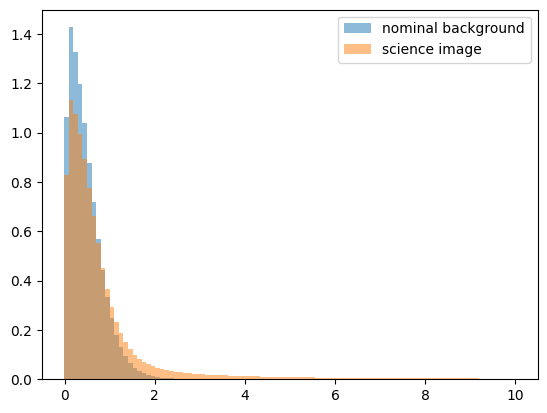

In [129]:
min_pixel_value = 0.0001

bins = np.linspace(-0.01, 10, 100)
_ = plt.hist(
    nominal_bkg[nominal_bkg > min_pixel_value].flatten() / result.x[0],
    bins=bins,
    density=True,
    alpha=.5, 
    label='nominal background'
)


science_image = background_info['science_image_bkg_subtracted']
_ = plt.hist(
    science_image[science_image > min_pixel_value].flatten() / result.x[0],
    bins=bins,
    density=True,
    alpha=.5, 
    label='science image'
)


# x = np.linspace(0., 10, 1000)
# y = norm.pdf(x, scale=1) * 2  # half-normal
# plt.plot(x, y, label='half normal')

plt.legend()

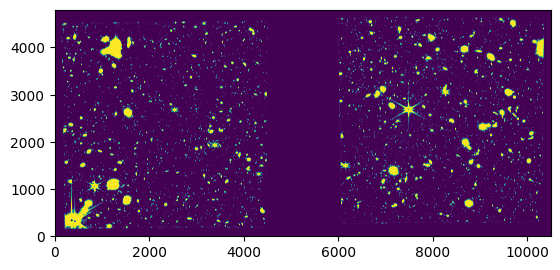

In [130]:
plt.imshow((science_image / result.x[0]) > 2, origin='lower')

In [131]:

# for chi-sq image, run this on each band to normalise, then sum the square of the individual pixel values for the y detection image
# (then optionally square-root for the R detection image)
# and run source detection as normal (with no further background subtraction, as the image is p of source in pixel)